In [10]:
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

class CNN_fe_classifier:
    def __init__(self, im_h, im_w):
        self.h = im_h
        self.w = im_w
        
    def load_data(self, data=None, labels=None, test_data=None, test_labels=None, load=False, model_only=False):
        if load:
            self.__load_model(model_only) 
        elif data.any() and labels.any():
            self.data = data
            self.labels = labels
            self.test_data = test_data
            self.test_labels = test_labels
        else:
            raise ValueError
        
    def fit(self, fe_labels, batch_size=32, epoch=10, verbose=1):
        self.fe_labels = fe_labels
        self.model = self.__compile_cnn()
        self.model, hist = self.__train_cnn(self.model, batch_size, epoch, verbose)
        self.history = hist
        
    def __compile_cnn(self):
        K.set_image_dim_ordering('th') # th - Theano input (channel,size_lines,size_columns), 
                                        # tf - Tensorflow input (size_lines,size_columns,channel)
        model = Sequential()
        model.add(Convolution2D(self.h+4,(3,3),activation='relu',input_shape=(1,self.h,self.w)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.33))      
        model.add(Dense(len(self.fe_labels),activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    def __train_cnn(self, model, batch_size, epoch, verbose):
        hist = model.fit(self.data, self.labels, batch_size, epoch, verbose)
        return (model, hist)
    
    def show_face(self, number):
        plt.imshow(self.data[face][0]*255)
        plt.title(self.fe_labels[np.argmax(self.labels[face])])
        plt.show()
    
    def evaluate(self, verbose=1):
        if not self.test_data.any() or not self.test_labels.any():
            raise ValueError
        score = self.model.evaluate(self.test_data, self.test_labels, verbose)
        print(score)
    
    def predict(self, pred_data, verbose=1):
        pred = self.model.predict(pred_data, verbose)
        return pred
    
    def show_pred_img(self, pred_data, pred_label, emotions, verbose=1):
        plt.imshow(pred_data[0]*255)
        true = emotions[np.argmax(pred_label)]
        pred = self.predict(np.array([pred_data]), verbose)
        pred_label = emotions[np.argmax(pred[0])]
        pred_perc = pred[0][np.argmax(pred[0])]
        pred_perc *= 100
        plt.title(f'True label: {true}\nPredicted: {pred_label} with {pred_perc:.2f}%')
        plt.show()
    
    def save_model(self, model_only=False):
        pickle.dump(self.model,
                    open('fer_model.pkl', 'wb'),
                    protocol=4)
        if not model_only:
            pickle.dump(self.labels,
                        open('fer_y_train.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.test_labels,
                        open('fer_y_test.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.test_data,
                        open('fer_X_test.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.data,
                        open('fer_X_train.pkl', 'wb'),
                        protocol=4)
        
    def __load_model(self, model_only=False):
        self.model = pickle.load(open('fer_model.pkl', 'rb'))
        if not model_only:
            self.labels = pickle.load(open('fer_y_train.pkl', 'rb'))
            self.test_labels = pickle.load(open('fer_y_test.pkl', 'rb'))
            self.data = pickle.load(open('fer_X_train.pkl', 'rb'))
            self.test_data = pickle.load(open('fer_X_test.pkl', 'rb'))

In [68]:
import cv2
import numpy as np

class Video_fe:
    def __init__(self, cnn, emotions):   
        self.fe_cnn = cnn
        self.emotions = emotions
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    def start(self):
        # capture video from default camera
        cap = cv2.VideoCapture(0)
        while(True):
            ret, frame = cap.read()
            # flip frame horizontaly, so it looks like in the mirror 
            frame = cv2.flip(frame,1)
            # create gray representation of frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # find faces on gray frame
            faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)
            for (x,y,w,h) in faces[:1]:
                # crop face from image
                face_array = gray[x:x+w, y:y+h]
                # resize face
                face_array = cv2.resize(face_array, (48,48), interpolation=cv2.INTER_AREA)
                face_array = face_array.astype(float)
                # normalize image
                face_array /= 255
                pred = 0
                try:
                    # predict facial expression
                    pred = self.fe_cnn.predict(np.array([np.array([face_array])])) # resize image to (1,1,48,48)
                except:
                    break
                # find label of predicted emotion
                pred_label = self.emotions[np.argmax(pred[0])]
                # probability of prediction
                pred_perc = pred[0][np.argmax(pred[0])]
                pred_perc *= 100
                text = f'{pred_label}: {pred_perc:.2f}%'
                # show rectangle with text upon face
                cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2) #left top (x, y), bottom right, (r,g,b), line width
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(frame, text, (x-5,y-5), font, 1, (255,255,0), 2, cv2.LINE_AA) # text, bottom left (x, y), font, font size, (r,g,b), thickness, anti-aliassing
            cv2.imshow('Emotion recognition',frame)
            # press key `q` to exit
            if cv2.waitKey(1) & 0xff == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

In [5]:
# dimensions of input image
hgh, wdth = 48,48
# facial expression labels
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
from keras.utils import np_utils
import numpy as np

fe_train = np.genfromtxt('../../../Datasets/fer2013/fer2013.csv', delimiter=';', dtype=str)

y = fe_train[1:,0]
y = np_utils.to_categorical(y, len(np.unique(y)))

X = fe_train[1:,1]
X = np.array([np.array(x.split(' ')) for x in X])
X = X.reshape(X.shape[0],1,hgh,wdth)
X = X.astype('float32')
X /= 255

y_train = y[:32000]
y_test = y[32000:]
X_train = X[:32000]
X_test = X[32000:]

In [12]:
# train cnn
fe_cnn = CNN_fe_classifier(hgh, wdth)
fe_cnn.load_data(load=True, model_only=True)
#fe_cnn.load_data(X_train, y_train, X_test, y_test)
#fe_cnn.fit(emotions, epoch=20)
#fe_cnn.save_model(model_only=True)
# start video stream

In [1]:
video_fe = Video_fe(fe_cnn, emotions)
video_fe.start

NameError: name 'Video_fe' is not defined

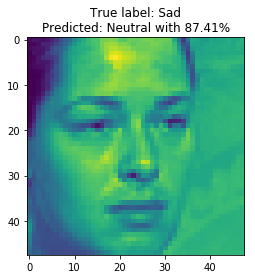

In [26]:
face=921
fe_cnn.show_pred_img(X_test[face], y_test[face], emotions)

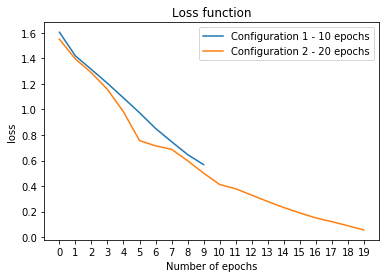

In [66]:
loss_1 = [1.6050, 1.4195, 1.3129, 1.2049, 1.0903, 0.9744, 0.8516, 0.7477, 0.6468, 0.5676]
loss_2 = [1.5506, 1.395, 1.2871, 1.1567, 0.981, 0.756, 0.715, 0.6879, 0.5987, 0.5012, 
          0.4123, 0.3789, 0.3287, 0.2791, 0.2318, 0.1897, 0.1505, 0.1211, 0.0891, 0.0562]
plt.plot(range(len(loss_1)), loss_1,
         range(len(loss_2)), loss_2)
plt.title('Loss function')
plt.xticks(range(len(loss_2)))
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend(['Configuration 1 - 10 epochs', 'Configuration 2 - 20 epochs'])
plt.show()

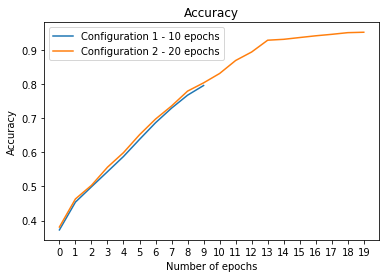

In [65]:
acc_1 = [0.3727, 0.4541, 0.4989, 0.5431, 0.5876, 0.6376, 0.6863, 0.7291, 0.7670, 0.7953]
acc_2 = [0.3812, 0.4634, 0.5031, 0.5562, 0.5989, 0.6512, 0.6971, 0.7354, 0.7789, 0.8031, 
         0.8305, 0.8685, 0.8934, 0.9279, 0.9305, 0.9357, 0.9408, 0.9451, 0.95, 0.9512]
plt.plot(range(len(acc_1)), acc_1,
         range(len(acc_2)), acc_2)
plt.title('Accuracy')
plt.xticks(range(len(acc_2)))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Configuration 1 - 10 epochs', 'Configuration 2 - 20 epochs'])
plt.show()